In [1]:
"""
Challenge Set 1
Topic:        Benson MTA Turnstile Data
Date:         04/18/2016
Name:         Will Huguenin
"""

#Challenge (1): Create Turnstile-Level Dictionary from Weekly MTA Datafiles
import csv
from collections import defaultdict
import datetime as dt

"""
This function reads in multiple MTA datafiles and converts them into a dictionary in format:
{(CA,Unit,SCP,Station): [[Rest of Row 1], [Rest of Row 2], etc.]}

All the user has to do is set the timestamp of the first and last 
datafile to read in.

For example, read_in_data("04/18/2015","05/02/2015") will read in the three MTA datafiles:
04/18/2015
04/25/2015
05/02/2015
"""

def read_in_data(start,stop):
    start_date=dt.datetime.strptime(start,"%m/%d/%Y").date() #convert input start date string to date object
    stop_date=dt.datetime.strptime(stop,"%m/%d/%Y").date() #convert input stop date to date object
    d=defaultdict(list) #intialize dictionary
    
    while start_date<=stop_date: #loops through each weekly datafile between start and stop date
        file_date="{:%y%m%d}".format(start_date) #format date to match MTA CSV file datestamps
        file_name="turnstile_"+file_date+".txt" #create file name
        f=list(csv.reader(open(file_name))) #read in CSV file as nested list (e.g. [[Row 1], [Row 2], ...])
        
        for i in range(1,len(f)): #loop through rows of each file, skipping header names. Create dictionary. 
            key=tuple(f[i][:4])
            val=[x.strip() for x in f[i][4:]]
            
            d[key].append(val)
 
        start_date+=dt.timedelta(days=7) #increment to next week and repeat read in/ dict creation :)
    
    return d
ts_dict=read_in_data("04/18/2015","05/02/2015")

#Print only first few values for first key (I'll use this function throughout)
def print_d(d,n):
    for i in range(n):
        print d.keys()[0], d[d.keys()[0]][i]

print_d(ts_dict,3)

('A030', 'R083', '01-06-00', '23 ST-5 AVE') ['NR', 'BMT', '04/11/2015', '00:00:00', 'REGULAR', '0005795917', '0003233359']
('A030', 'R083', '01-06-00', '23 ST-5 AVE') ['NR', 'BMT', '04/11/2015', '04:00:00', 'REGULAR', '0005795984', '0003233374']
('A030', 'R083', '01-06-00', '23 ST-5 AVE') ['NR', 'BMT', '04/11/2015', '08:00:00', 'REGULAR', '0005796003', '0003233396']


In [2]:
#Challenge (2): Convert Audit Period to Datetime Object; Calculate Entries per Audit Period
from dateutil.parser import parse as dt_pse

def entries_per_audit(d):
    new_d=defaultdict(list) #initialize new dict
    
    for k in d:
        temp_list=[] #create temp list to hold dates and entry conts
        
        for i in range(0,len(d[k])): #loop through turnsiles
            audit_dt=dt_pse(d[k][i][2]+" "+d[k][i][3]) #create audit datetime object
            cum_entry=int(d[k][i][5])
            temp_list.append([audit_dt,cum_entry])
            
        temp_list.sort() #sort list of audit datetimes, cumulative entry counts by datetime earliest->latest
        
        for i in range(1,len(temp_list)):
            entries=temp_list[i][1]-temp_list[i-1][1] #calculate audits per entry period
            new_d[k].append([temp_list[i][0], entries]) #add to output dictionary
              
    return new_d

audit_counts=entries_per_audit(ts_dict)
print_d(audit_counts,3)

('A030', 'R083', '01-06-00', '23 ST-5 AVE') [datetime.datetime(2015, 4, 11, 4, 0), 67]
('A030', 'R083', '01-06-00', '23 ST-5 AVE') [datetime.datetime(2015, 4, 11, 8, 0), 19]
('A030', 'R083', '01-06-00', '23 ST-5 AVE') [datetime.datetime(2015, 4, 11, 12, 0), 87]


In [3]:
#Challenge (3): Aggregate counts for each turnstile-date
def sum_counts_by_ts_date(d):
    new_d=defaultdict(list)
    
    for k in d:
        temp_dict=defaultdict(int)
        
        for i in range(0,len(d[k])):
            date=d[k][i][0].date()
            entries=d[k][i][1]
            
            temp_dict[date]=temp_dict.get(date, 0)+entries
            
        new_d[k]=temp_dict.items()
    
    return new_d

counts_by_ts_date=sum_counts_by_ts_date(audit_counts)
print_d(counts_by_ts_date,3)

('A030', 'R083', '01-06-00', '23 ST-5 AVE') (datetime.date(2015, 4, 16), 2681)
('A030', 'R083', '01-06-00', '23 ST-5 AVE') (datetime.date(2015, 4, 17), 2502)
('A030', 'R083', '01-06-00', '23 ST-5 AVE') (datetime.date(2015, 4, 28), 2710)


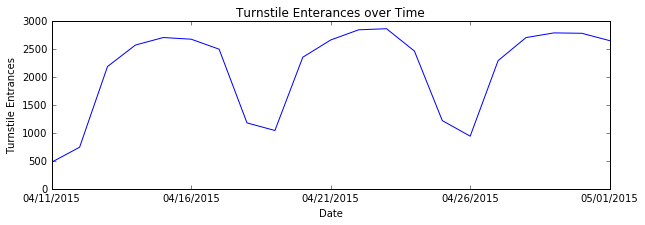

In [4]:
#Challenge (4): Plot Enterances over time (by date) for first turnstile in dictionary
%matplotlib inline
import matplotlib.pyplot as plt

def plot_ts_time_series(d):
    date_count=d[d.keys()[0]] #convert dictionary to nested list
    date_count.sort() #sort by first element (datetime)

    dates=[]
    counts=[]

    for each in date_count:
        dates.append(each[0].strftime("%m/%d/%Y"))
        counts.append(each[1])
        
    plt.figure(figsize=(10,3))
    plt.plot(counts)
    plt.xticks([x for x in range(0,len(dates),5)],dates[::5])
    plt.title("Turnstile Enterances over Time")
    plt.xlabel("Date")
    plt.ylabel("Turnstile Entrances")
    
plot_ts_time_series(counts_by_ts_date) #need to fix x tick marks

In [11]:
#Challenges (5): Aggregate Entry Counts by CA-Unit-Station-Date
def sum_counts_by_group_date(d):
    new_d=defaultdict(list)
    
    for k, v in d.items(): #loop through turnstiles
        for i in range(0, len(v)): #for each turnstile, loop through daily counts
            new_key=(k[0],k[1],k[3],v[i][0]) #create a new key representing TS group-date combo
            entries=v[i][1]
            
            new_d[new_key]=new_d.get(new_key, 0)+entries #Sum counts across records for each key (TS Group-Date)
    
    return new_d

counts_by_group_date=sum_counts_by_group_date(counts_by_ts_date)

print counts_by_group_date.items()[0:3]

[(('J013', 'R380', 'GATES AVE', datetime.date(2015, 5, 1)), 7013), (('R257', 'R182', '116 ST', datetime.date(2015, 4, 29)), 6890), (('B010', 'R412', 'BOTANIC GARDEN', datetime.date(2015, 4, 21)), 2099)]


In [12]:
#Challenge (6): Aggregate Entry Counts by Station-Date
def sum_counts_by_station_date(d):
    new_d=defaultdict(list)
    
    for k, v in d.items(): #loop through turnstiles
        for i in range(0,len(v)): #for each ts, loop through daily counts
            new_key=(k[3],v[i][0]) #create a new key reprsenting the station-date combo
            entries=v[i][1]
        
            new_d[new_key]=new_d.get(new_key, 0)+entries #sum counts across records for each key (station-date)
        
    return new_d
    
counts_by_station_date=sum_counts_by_station_date(counts_by_ts_date)
print counts_by_station_date.items()[0:3]

[(("PRINCE ST-B'WAY", datetime.date(2015, 4, 13)), 13548), (('103 ST', datetime.date(2015, 4, 17)), 36405), (('DITMARS BL-31 S', datetime.date(2015, 4, 16)), 18396)]


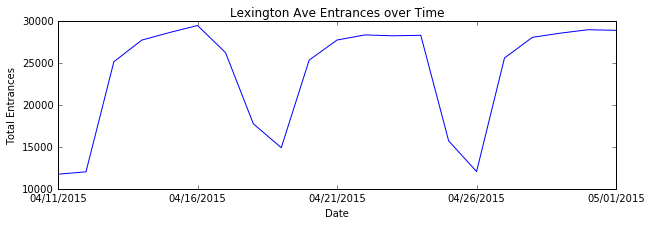

In [15]:
#Challenge (7): Plot the Time Series for a Specific Station
def series_by_station(station):
    time_series=counts_by_station_date.items() #convert dictionary to list of tuples
    time_series.sort() #sort by first tuple in list (by station, then date)
    
    dates=[]
    counts=[]
    
    for each in time_series:
        if each[0][0]==station:
            dates.append(each[0][1].strftime("%m/%d/%Y"))
            counts.append(each[1])
                          
    plt.figure(figsize=(10,3))
    plt.plot(counts)
    plt.xticks([x for x in range(0,len(dates),5)], dates[::5])
    plt.title(station.title()+" Entrances over Time")
    plt.xlabel("Date")
    plt.ylabel("Total Entrances")

series_by_station("LEXINGTON AVE")

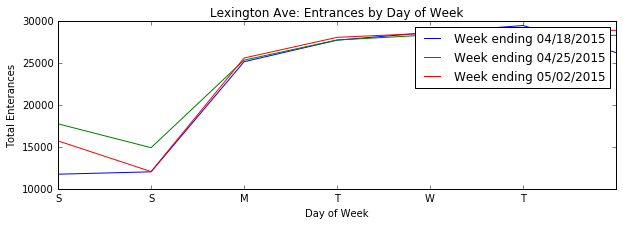

In [20]:
#Challenge 8: Plot Time Series for Specific Station by Day of Week, with multiple lines for multiple weeks
def dow_start_sat(date):
    if date.weekday()==5:
        new_dow=0
    elif date.weekday()==6:
        new_dow=1
    else:
        new_dow=date.weekday()+2
        
    return new_dow

def counts_by_dow(station,week):
    time_series=counts_by_station_date.items()
    time_series.sort()
    dates=[]
    counts=[]
    
    for each in time_series:
        date=each[0][1]
        dow=dow_start_sat(date)
        week_end=date+dt.timedelta(days=(7-dow))

        if each[0][0]==station and week_end.strftime("%m/%d/%Y")==week:
            counts.append(each[1])
    
    return counts

plt.figure(figsize=(10,3))
plt.plot(counts_by_dow("LEXINGTON AVE","04/18/2015"), label="Week ending 04/18/2015")
plt.plot(counts_by_dow("LEXINGTON AVE","04/25/2015"), label="Week ending 04/25/2015")
plt.plot(counts_by_dow("LEXINGTON AVE","05/02/2015"), label="Week ending 05/02/2015")
plt.legend()
plt.xlabel("Day of Week")
plt.ylabel("Total Enterances")
plt.xticks([x for x in range(0,6)], ["S","S","M","T","W","T","F"])
plt.title("Lexington Ave: Entrances by Day of Week")

In [28]:
#Challenge (9): Sum the total passenger traffic for each station
def sum_counts_by_station(d):
    new_d=defaultdict(int)

    for k, v in d.items():
        new_key=k[0]
    
        new_d[new_key]=new_d.get(new_key, 0)+v

    return new_d

counts_by_station=sum_counts_by_station(counts_by_station_date)

print counts_by_station.items()[0:5]




[('BOYD-88 ST', 52303), ('NEWKIRK PLAZA', 212300), ('PATH WTC', 320272), ('TREMONT AVE', -153705576), ('22 AVE-BAY PKY', 30666)]


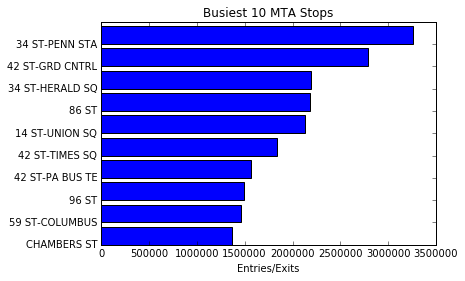

In [36]:
#Challenge (10): Plot the total passenger traffic by station, in decending order by busiest station
def plot_count_by_station(d):
    station_count=sorted(d.items(), key=lambda x: x[1])
    
    stations=[]
    counts=[]
    
    for each in station_count:
        if each[1]>(100*24*7*3) and each[1]<(11000*24*7*3): #remove outliers, roughly corresponding to 5th and 95th percentiles
            stations.append(each[0])
            counts.append(each[1])
            
    plt.barh([x for x in range(10)],counts[-10:])
    plt.yticks([x for x in range(10)],stations[-10:])
    plt.title("Busiest 10 MTA Stops")
    plt.xlabel("Entries/Exits")

plot_count_by_station(counts_by_station)